## Algorithm to predict the size of the Yerba Mate grains

It is based in a photo of the grains disposed in a white paper. The algorithm can detect the contours and calculate the equivalent width and length of each grain. Then the distribution of the particle sizes is shown.

1. First the image is loaded and the cv2 library is used to process the image

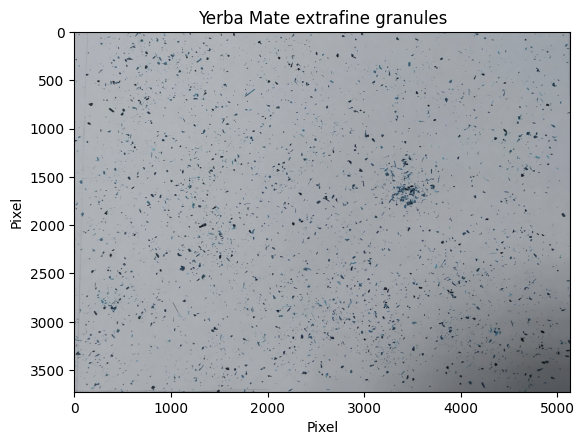

In [27]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

fname = 'YM2_extrafine_200x150.jpg'
img = cv2.imread(fname) #YM_media3_2914x1758

#YM2_fine_150x100 --> 2684/150 = 17.89  ; 1768/100 = 17.68 resolution
#YM2_gruesa_200x150 --> 2454/200=12.27 ; 1826/150= 12.17
#YM2_extrafine_200x150 -->  5136/200 = 25.68 ; 3726/150 = 24.84

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
gray_blurred = cv2.GaussianBlur(gray, (7, 7), 0)

plt.imshow(img)
plt.title('Yerba Mate extrafine granules')
plt.xlabel('Pixel')
plt.ylabel('Pixel')
plt.show()



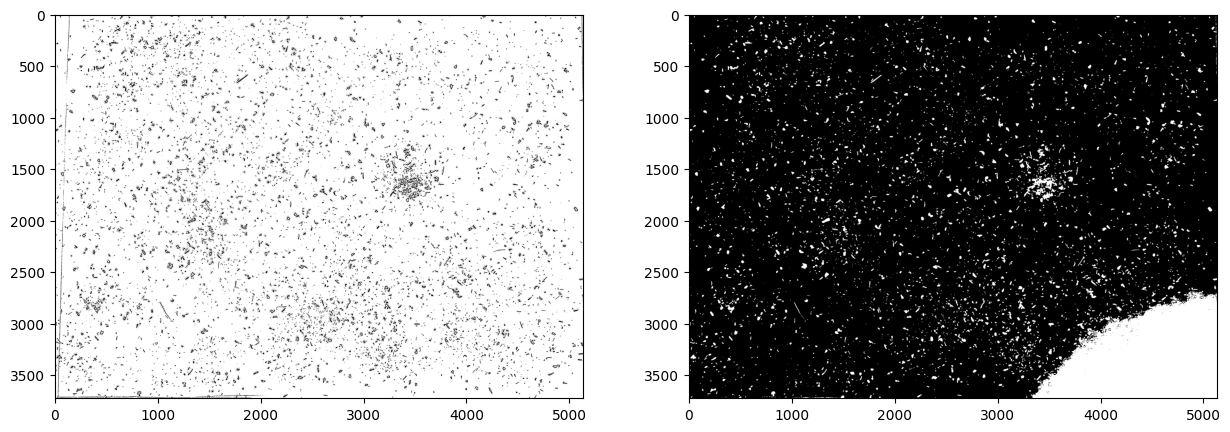

In [29]:
# Get the pixel resolution in pixels per millimeter (Enter valid values based on your image)
#pixel_resolution_x = float(input("Enter horizontal pixel resolution (pixels/mm): ")) #2234/100=22.34
#pixel_resolution_y = float(input("Enter vertical pixel resolution (pixels/mm): "))   #1358/60= 22.62

pixel_resolution_x = 25.6
pixel_resolution_y = 24.84

# Apply thresholding to segment the sticks from the background
thresh = cv2.threshold(gray_blurred, 100, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
thresh2 = cv2.adaptiveThreshold(gray_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11,2)
fig, axx = plt.subplots(1, 2, figsize=(15,10))
axx[0].imshow(cv2.cvtColor(thresh2, cv2.COLOR_BGR2RGB))
axx[1].imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
# Find contours of the sticks
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)



### Some GIT commands

- cd ~/projects/my_notebooks      -->   Navigate to the notebook directory
- code my_notebook.ipynb           --> Open the notebook in VS Code

#### Make changes in VS Code
#### Save changes: Ctrl + S (Windows/Linux) or Cmd + S (macOS)
-git add my_notebook.ipynb         # Stage the changes
-git commit -m "Updated analysis"   # Commit the changes
-git push origin main               # Push changes to the main branch (if needed)

In WLS:   The Windows drive letters (like C:) are mapped to /mnt/c in WSL.
ls /mnt/c/  --> to access the disk
cd /mnt/c/Users/YourUsername/Pictures --> or navigate to path